In [1]:
import pandas as pd
import numpy as np

from dataprep.clean import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from optuna import create_study, visualization
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
import shap
import kaleido
# import plotly.io as pio
# pio.kaleido.scope.default_format = "svg"
import matplotlib.pyplot as plt
import joblib

import machine_learning_pipeline as mlp
%load_ext autoreload
%autoreload 2

c:\Users\Dell\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\Dell\AppData\Local\Temp/ipykernel_12268/1090608179.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466


### Data Wrangling

#### Loading train and test dfs

In [2]:
dataset_folder = 'S3 E26 Multi-Class Prediction of Cirrhosis Outcomes'

train_df = pd.read_csv(f'{dataset_folder}/train.csv')
test_df = pd.read_csv(f'{dataset_folder}/test.csv')

# cleaning the headers
train_df = clean_headers(train_df)
# confirming the id is unique for each row and setting it 
# as the index
assert train_df.id.nunique() == len(train_df)
train_df = train_df.set_index('id')

test_df = clean_headers(test_df)
assert test_df.id.nunique() == len(test_df)
test_df = test_df.set_index('id')

train_df

Column Headers Cleaning Report:
	19 values cleaned (95.0%)
Column Headers Cleaning Report:
	18 values cleaned (94.74%)


n_days             drug    age sex ascites hepatomegaly spiders edema  \
id                                                                            
0        999  D-penicillamine  21532   M       N            N       N     N   
1       2574          Placebo  19237   F       N            N       N     N   
2       3428          Placebo  13727   F       N            Y       Y     Y   
3       2576          Placebo  18460   F       N            N       N     N   
4        788          Placebo  16658   F       N            Y       N     N   
...      ...              ...    ...  ..     ...          ...     ...   ...   
7900    1166  D-penicillamine  16839   F       N            N       N     N   
7901    1492          Placebo  17031   F       N            Y       N     N   
7902    1576  D-penicillamine  25873   F       N            N       Y     S   
7903    3584  D-penicillamine  22960   M       N            Y       N     N   
7904    1978  D-penicillamine  19237   F       N            N       N     N   

      bilirubin  cholesterol  albumin  copper  alk_phos    sgot  \
id                                                                
0           2.3        316.0     3.35   172.0    1601.0  179.80   
1           0.9        364.0     3.54    63.0    1440.0  134.85   
2           3.3        299.0     3.55   131.0    1029.0  119.35   
3           0.6        256.0     3.50    58.0    1653.0   71.30   
4           1.1        346.0     3.65    63.0    1181.0  125.55   
...         ...          ...      ...     ...       ...     ...   
7900        0.8        309.0     3.56    38.0    1629.0   79.05   
7901        0.9        260.0     3.43    62.0    1440.0  142.00   
7902        2.0        225.0     3.19    51.0     933.0   69.75   
7903        0.7        248.0     2.75    32.0    1003.0   57.35   
7904        0.7        256.0     3.23    22.0     645.0   74.40   

      tryglicerides  platelets  prothrombin  stage status  
id                                                         
0              63.0      394.0          9.7    3.0      D  
1              88.0      361.0         11.0    3.0      C  
2              50.0      199.0         11.7    4.0      D  
3              96.0      269.0         10.7    3.0      C  
4              96.0      298.0         10.6    4.0      C  
...             ...        ...          ...    ...    ...  
7900          224.0      344.0          9.9    2.0      C  
7901           78.0      277.0         10.0    4.0      C  
7902           62.0      200.0         12.7    2.0      D  
7903          118.0      221.0         10.6    4.0      D  
7904           85.0      336.0         10.3    3.0      C  

[7905 rows x 19 columns]

#### Handling the Target/Dependent Variable

In [6]:
target = 'status'
# defining the type of our target: 'continuous', 'binary' or 'multiclass'
target_type = 'multiclass'

# checking that the target_type is a valid one
assert target_type in ['continuous', 'binary', 'multiclass']

# encoding the target for categorical string target columns
if target_type != 'continuous':
    le = LabelEncoder()
    train_df[target] = le.fit_transform(train_df[target].tolist())
    target_classes = list(le.classes_)
    print('Target Encoding:')
    for i, clss in enumerate(target_classes): print(target + ' ' + str(clss) + ' -> ' + target + ' ' + str(i)) 

Target Encoding:
status C -> status 0
status CL -> status 1
status D -> status 2


#### Splitting features into numerical and categorical types

In [7]:
# creating a dataframe that lets us know the data types of each one of our 
# features
data_types = pd.DataFrame(train_df.dtypes, columns=['feature_type'])
data_types['unique_values'] = train_df.nunique()
data_types

feature_type  unique_values
n_days               int64            461
drug                object              2
age                  int64            391
sex                 object              2
ascites             object              2
hepatomegaly        object              2
spiders             object              2
edema               object              3
bilirubin          float64            111
cholesterol        float64            226
albumin            float64            160
copper             float64            171
alk_phos           float64            364
sgot               float64            206
tryglicerides      float64            154
platelets          float64            227
prothrombin        float64             49
stage              float64              4
status               int64              3

Although all the columns are numeric, the small number of diffetent values for some columns suggests that the they could be interpreted as categorical

In [8]:
# setting a threshold to determine categorical columns versus numerical
cat_threshold = 10
numerical_features, categorical_features = mlp.split_features(df=train_df, target_col=target, categorical_threshold=cat_threshold)

The numerical features are: ['bilirubin', 'cholesterol', 'albumin', 'copper', 'alk_phos', 'sgot', 'tryglicerides', 'platelets', 'prothrombin', 'stage', 'n_days', 'age']
The categorical features are: ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders', 'edema']


### EDA

#### Pairplot
These graphs help us visualize the relationships between our numerical features and the target. For numerical targets the last row of the pairplot corresponds to the target; for categorical targets, the target can be seen as the marker color in each graph.

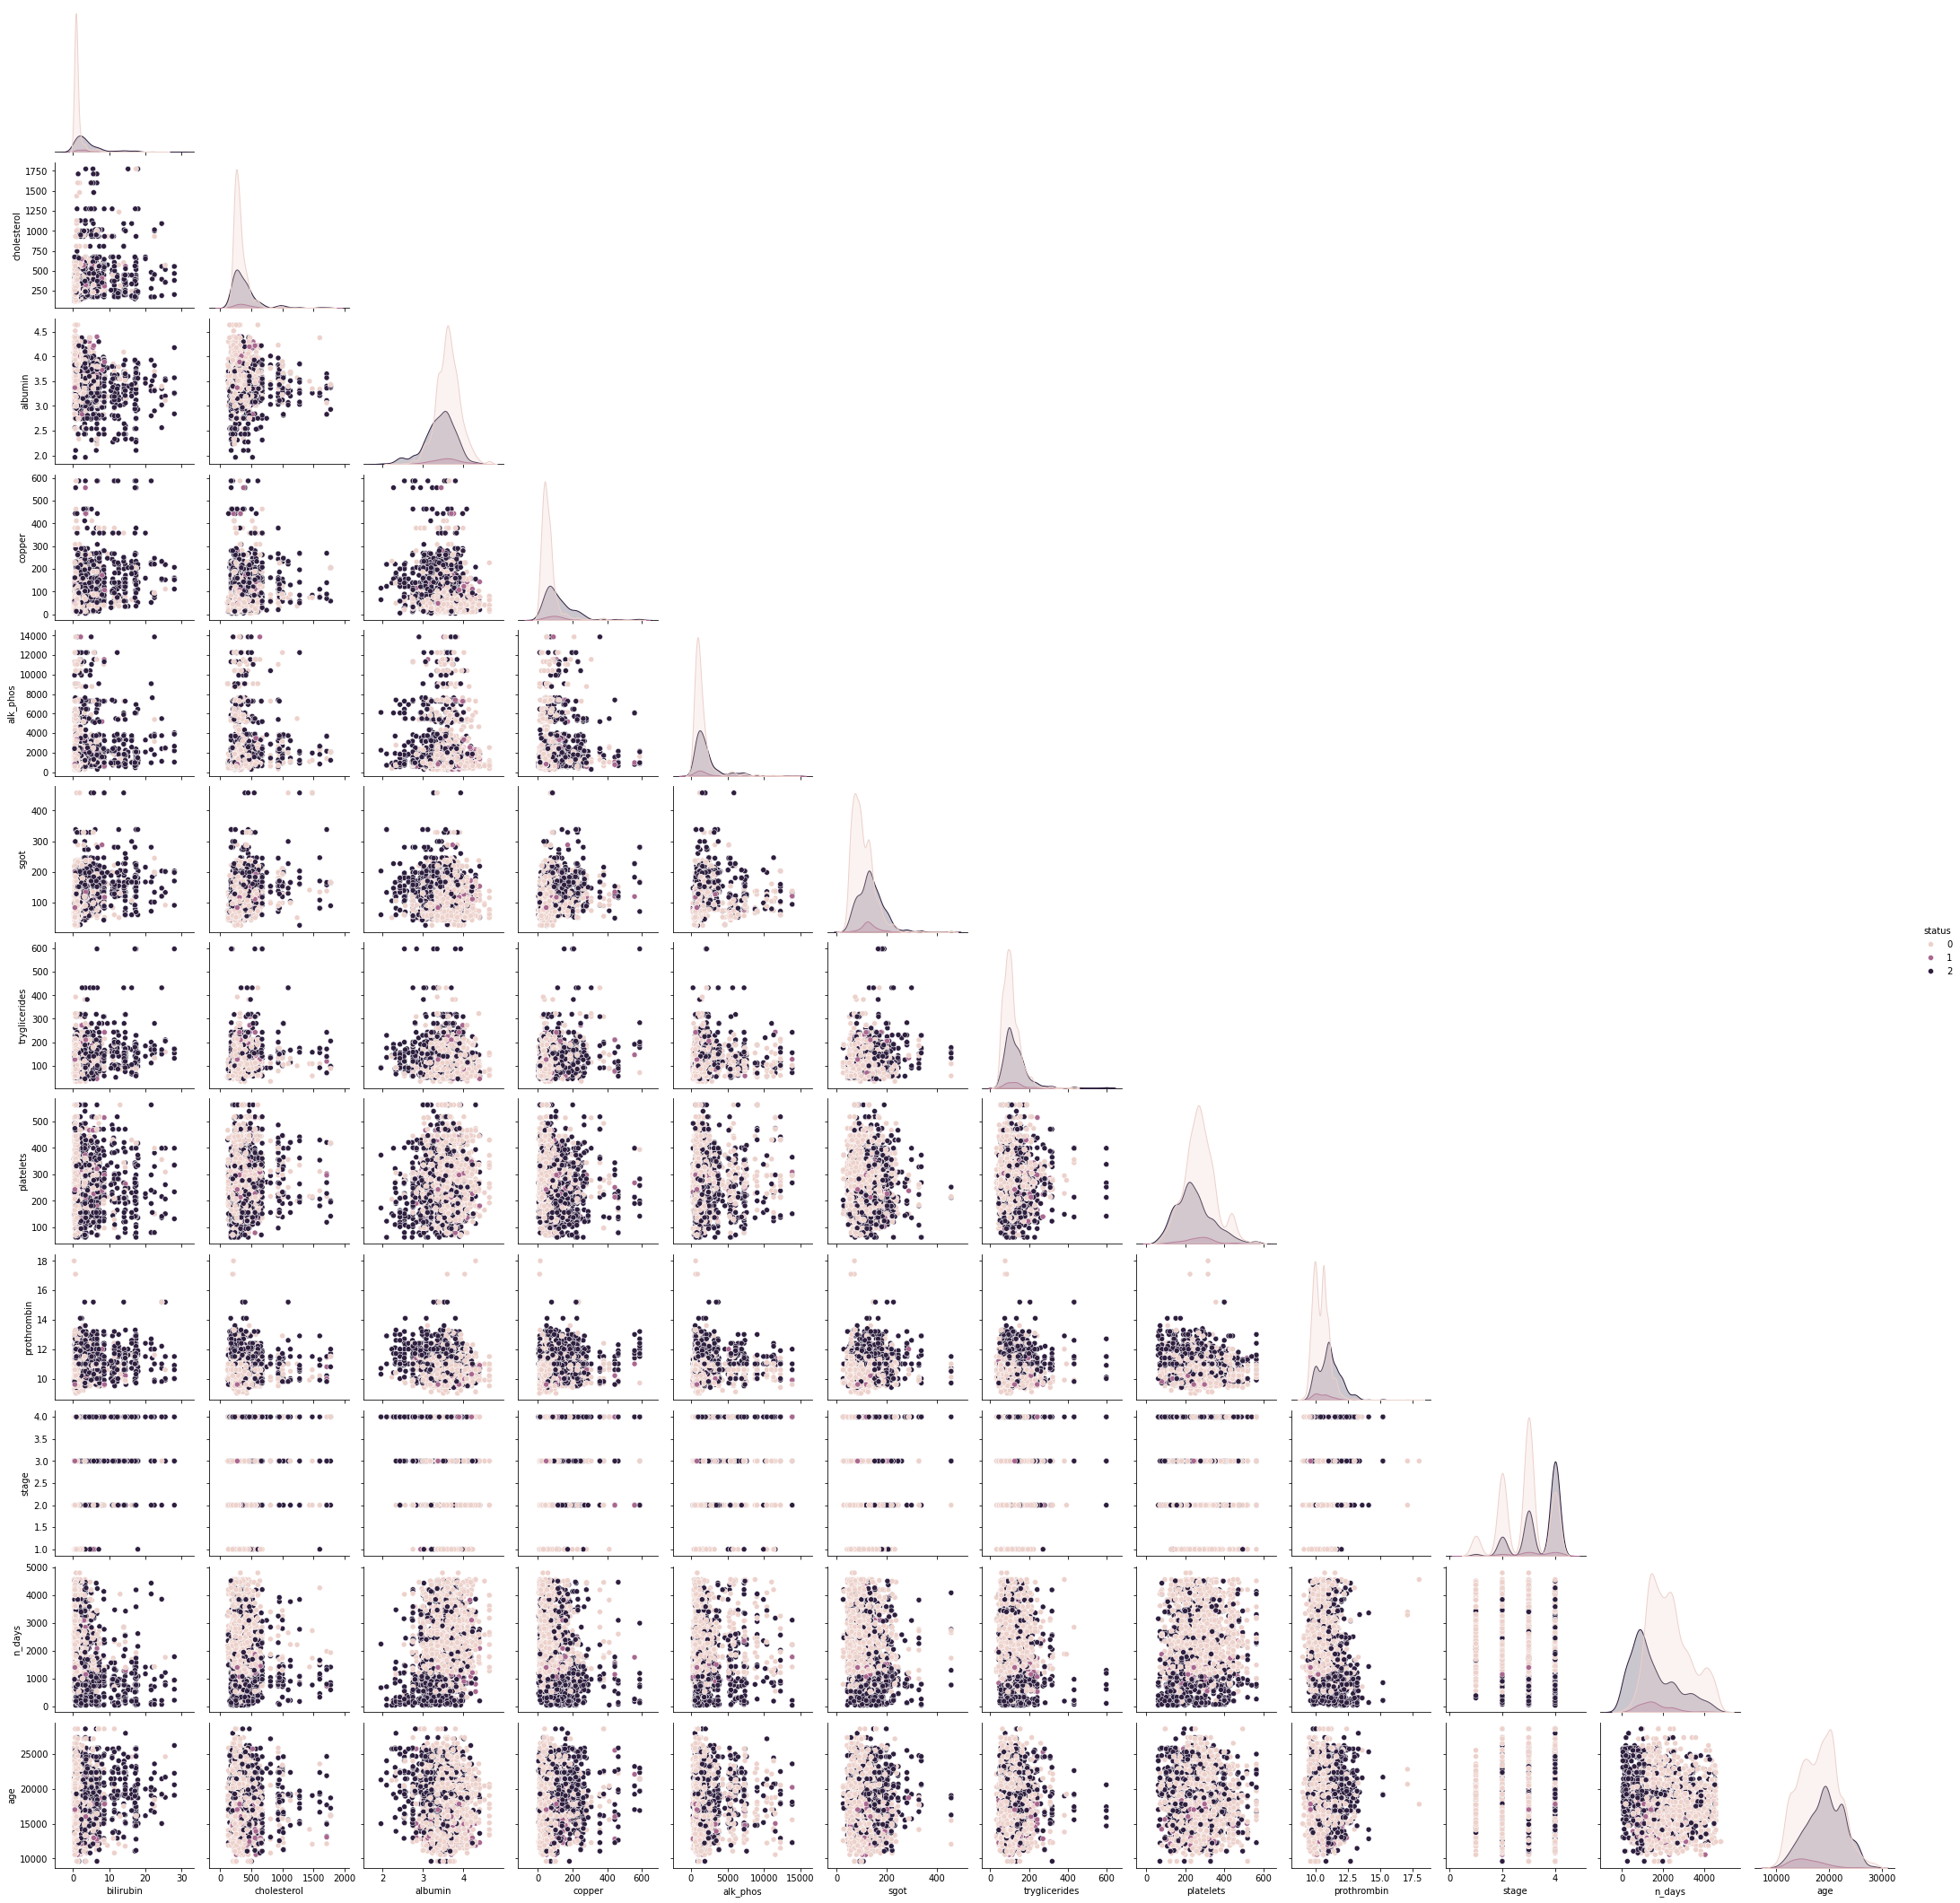

In [9]:
mlp.pairplot(df=train_df.reset_index(),
             numerical_features=numerical_features,
             target_type=target_type,
             target_col=target,
             sample=0.5)

#### Numerical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the numerical features

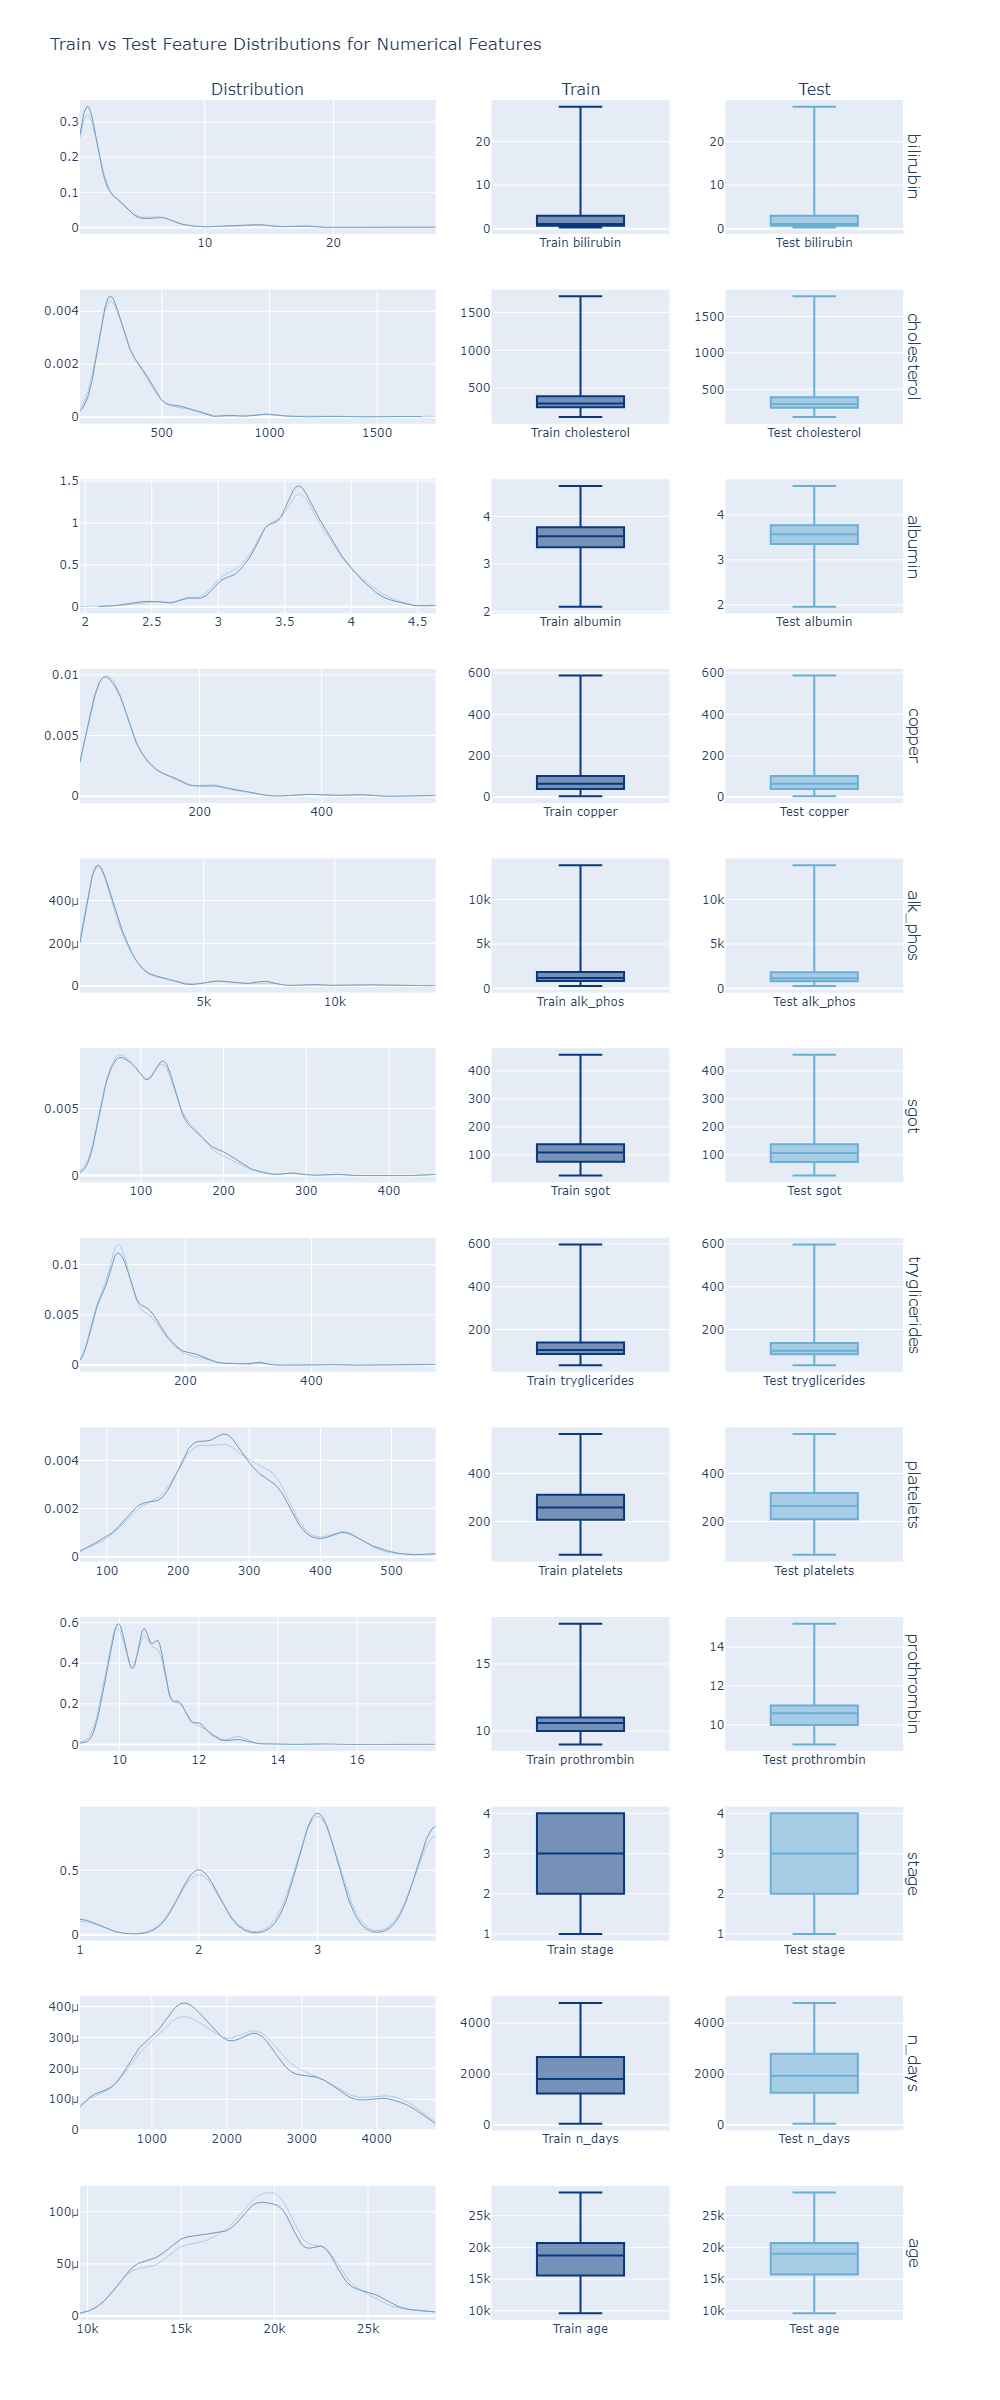

In [12]:
mlp.train_test_distribution_plots(train_df,
                                  test_df,
                                  numerical_features,
                                  sample=0.5,
                                  renderer='png'
                                  ) 

#### Categorical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the cateorical features

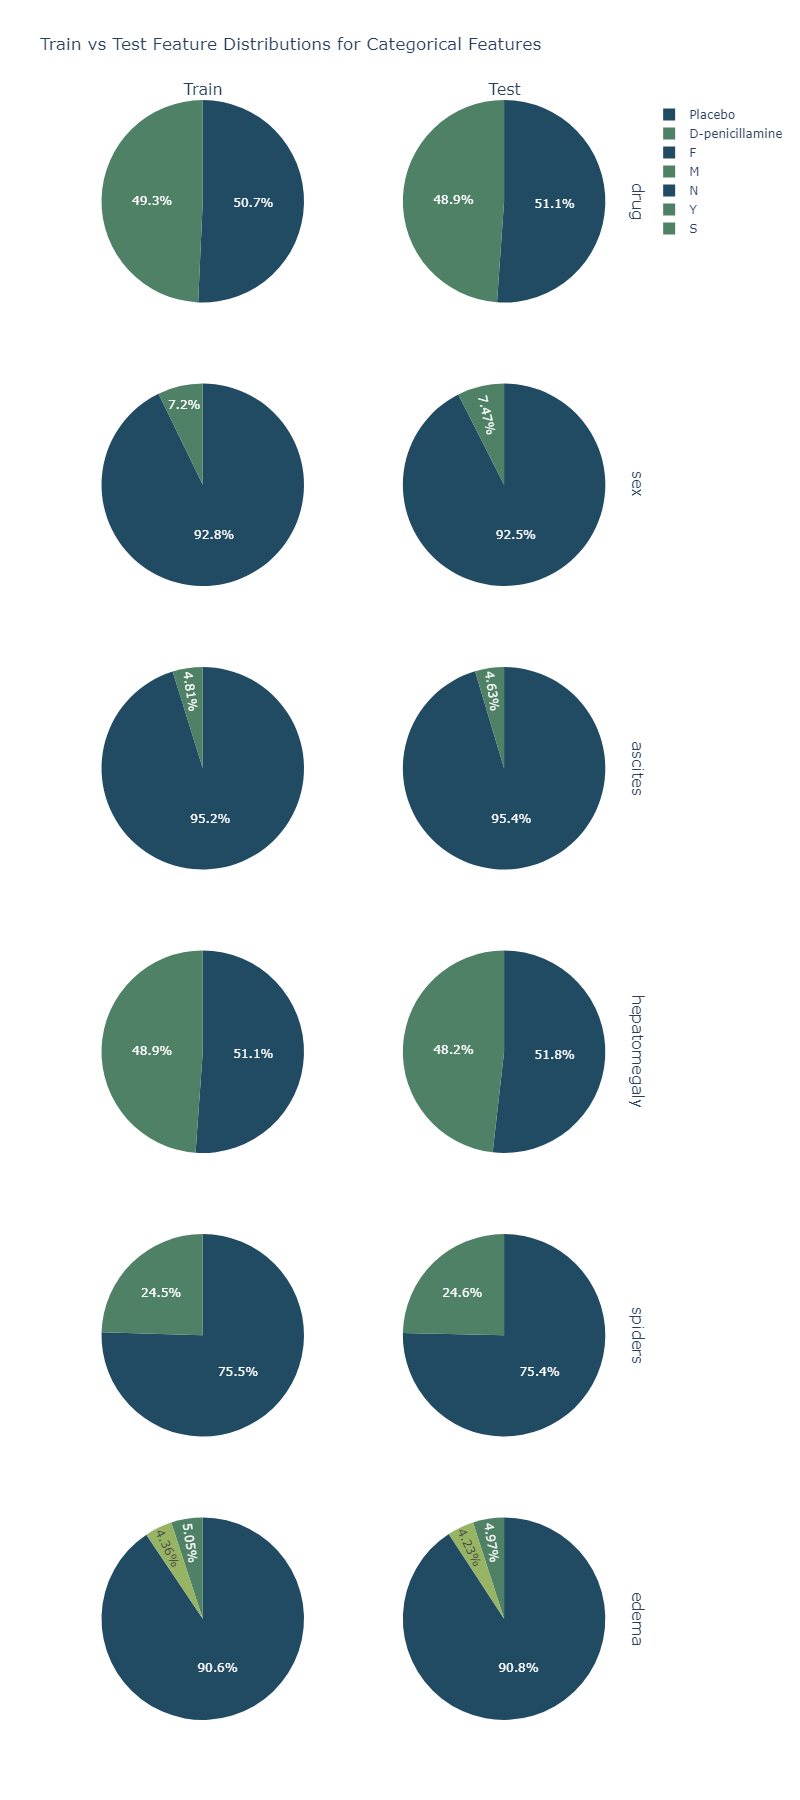

In [13]:
mlp.train_test_categorical_piecharts(train_df,
                                     test_df,
                                     categorical_features,
                                     renderer='png'
                                     )

#### Correlation Matrix

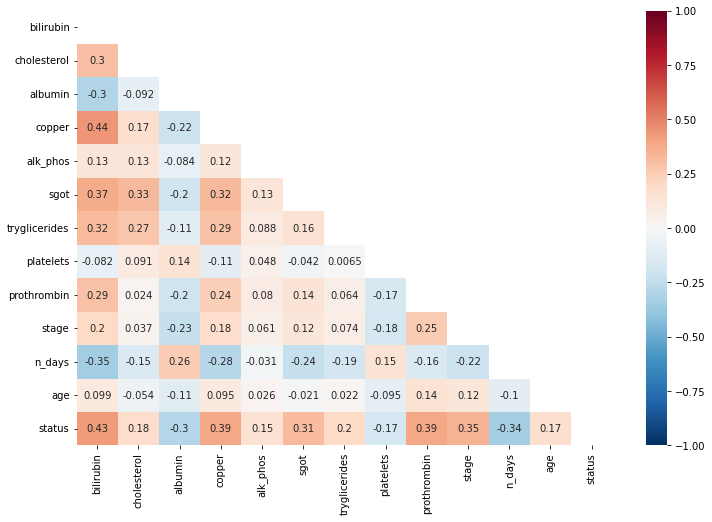

In [14]:
mlp.correlation_plot(train_df[numerical_features + [target]])

### Model Training with Optuna

#### Declaring variables needed for optimization step

In [15]:
# During the model fitting step, the optuna optimizer will include the algorithm 
# as one of the  hyperparameters of the model. It will try to find the one that 
# performs the best for our problem.

if target_type == 'continuous':    
    optimization_objective = 'regression'
    # available algorithms for regression tasks. 
    algorithms = [
                    # 'linear',
                    # 'ridge',
                    # 'histgb',                     
                    # 'extratrees', 
                    'lgb',
                    # 'xgb', 
                    # 'catboost'
                ] 
    
    # scoring for cross-validation
    optimization_scoring = 'neg_mean_squared_log_error'

elif target_type == 'binary':
    optimization_objective = 'classification'
    # available algorithms for binary classification tasks
    algorithms = [
                    # 'histgb',                     
                    # 'extratrees', 
                    'lgb',
                    # 'xgb', 
                    # 'catboost'
                ]
    # scoring for cross-validation
    optimization_scoring = 'roc_auc'

elif target_type == 'multiclass':
    optimization_objective = 'multiclass'
    # available algorithms for multiclass classification tasks
    algorithms = [
                    'histgb',                     
                    'lgb',
                ]
    # scoring for cross-validation
    optimization_scoring = 'neg_log_loss'

#### Model Optimization

In [16]:
pd.set_option('future.no_silent_downcasting', True)
with_imputation = False
with_interactions = False
with_feature_selection = False

train_df = train_df.dropna(subset=target)

if with_imputation:
    X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target, axis=1), 
                                                        train_df[target], 
                                                        test_size=0.2,
                                                        random_state=0)   
else:
    train_df_no_missing_vals = train_df.dropna().copy()
    X_train, X_test, y_train, y_test = train_test_split(train_df_no_missing_vals.drop(target, axis=1), 
                                                        train_df_no_missing_vals[target], 
                                                        test_size=0.2,
                                                        random_state=0)

# declaring our optuna study
factor = 2
# the pruner parameter helps make the optimization much faster as it will prune
# any iterations that don't look promising right from the start
study = create_study(study_name='optimization', 
                     direction='maximize',
                     pruner=SuccessiveHalvingPruner(reduction_factor=factor),
                     sampler=RandomSampler(seed=0))


# custom function to fit the model using smart hyperparameter search with optuna. This 
# parameter search is not restricted to the algorithm's hyperparameters. The algorithm
# itself is part of the parameters to be optimized. Data preprocessing decisions are 
# also included here, such as the scaling approach for numerical features, the encoding 
# technique for categorical variables, as well as feature selection.
study.optimize(lambda trial: mlp.objective(trial, 
                                           X_train, 
                                           y_train, 
                                           objective=optimization_objective,
                                           algorithms=algorithms,
                                           cv_scoring=optimization_scoring,
                                           numerical_columns=numerical_features, 
                                           categorical_columns=categorical_features,
                                           with_feature_selection=with_feature_selection,
                                           with_imputation=with_imputation, 
                                           with_interactions=with_interactions,
                                           base=factor, 
                                           n_rungs=4), 
               n_trials=100)

[I 2024-05-04 17:17:27,620] A new study created in memory with name: optimization
[I 2024-05-04 17:17:31,255] Trial 0 finished with value: -0.46468826540101366 and parameters: {'with_centering': False, 'with_scaling': True, 'categorical_encoder': 'onehot', 'algorithm': 'lgb', 'lambda_l1': 8.675307976899775e-05, 'lambda_l2': 1.0615904599004014, 'num_leaves': 247, 'feature_fraction': 0.6300649112954666, 'bagging_fraction': 0.8750350228495988, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 0 with value: -0.46468826540101366.
[I 2024-05-04 17:17:42,404] Trial 1 finished with value: -10.125932077182181 and parameters: {'with_centering': True, 'with_scaling': True, 'categorical_encoder': 'onehot', 'algorithm': 'histgb', 'max_iter': 877, 'learning_rate': 0.86269052207149, 'max_leaf_nodes': 42, 'max_depth': 10, 'min_samples_leaf': 40}. Best is trial 0 with value: -0.46468826540101366.
[I 2024-05-04 17:18:11,313] Trial 2 finished with value: -1.1183886804792258 and parameters: {'wit

In [17]:
save_model = False
if save_model:
    file_name = 'model'
    joblib.dump(study, f"{file_name}.pkl")

In [18]:
# saving the models best parameters and trial and printing its best score
best_model_params = study.best_params
best_trial = study.best_trial
# printing the score of the best model
print(study.best_value)

-0.44357893737724535


#### Optuna trials visualizations

In [19]:
visualization.plot_optimization_history(study)

In [20]:
visualization.plot_param_importances(study, target_name="ms")

#### Instantiating the model

In [21]:
# calling the best trial and instantiating the model
model = mlp.instantiate_model(best_trial, 
                              numerical_features, 
                              categorical_features, 
                              optimization_objective, 
                              algorithms,
                              with_feature_selection=with_feature_selection,
                              with_imputation=with_imputation,
                              with_interactions=with_interactions)
model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   PassthroughTransformer()),
                                                                  ('pandarizer',
                                                                   PassthroughTransformer()),
                                                                  ('interactions',
                                                                   PassthroughTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler(with_centering=False,
                                                                                with_scaling=False))]),
                                                  ['bilirubin', 'cholesterol',
                                                   'albumin', 'copper',
                                                   'alk_phos', 'sgot',
                                                   '...
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['drug', 'sex', 'ascites',
                                                   'hepatomegaly', 'spiders',
                                                   'edema'])])),
                ('model',
                 LGBMClassifier(bagging_fraction=0.7006379037008512,
                                bagging_freq=3,
                                feature_fraction=0.618726775598072,
                                lambda_l1=0.016484014406370918,
                                lambda_l2=7.693763169552984,
                                min_child_samples=40, num_leaves=195,
                                objective='multiclass', random_state=0,
                                verbosity=-1))])

In [22]:
# printing score on the test set
print(model.score(X_test,y_test))

0.8172043010752689


### Model Explainability with SHAP

#### Fitting the model on preprocessed data

In [23]:
best_model_params

{'with_centering': False,
 'with_scaling': False,
 'categorical_encoder': 'onehot',
 'algorithm': 'lgb',
 'lambda_l1': 0.016484014406370918,
 'lambda_l2': 7.693763169552984,
 'num_leaves': 195,
 'feature_fraction': 0.618726775598072,
 'bagging_fraction': 0.7006379037008512,
 'bagging_freq': 3,
 'min_child_samples': 40}

#### Applying preprocessing steps to our dataset and Fitting the model
To be able to compute the shap values we need the preprocessed dataset and the chosen model. We'll use the best_model_params dictionary to retrieve them

In [24]:
final_processor = model.named_steps['processor']
final_learner = model.named_steps['model']

X_train_preprocessed = final_processor.transform(X_train)
X_test_preprocessed = final_processor.transform(X_test)

if with_imputation:
    train_df_preprocessed = final_processor.transform(train_df)
else:
    train_df_preprocessed = final_processor.transform(train_df_no_missing_vals)

if with_interactions:
    processed_numerical_features = final_processor.named_transformers_['numerical_pipeline']['interactions'].get_feature_names_out()
else:
    processed_numerical_features = numerical_features

if with_imputation:
    get_features_step = 'imputer'
else:
    get_features_step = 'encoder'
processed_categorical_features = final_processor.named_transformers_['categorical_pipeline'][get_features_step].get_feature_names_out().tolist()

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, 
                                    columns=processed_numerical_features + processed_categorical_features, 
                                    index=X_train.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, 
                                   columns=processed_numerical_features + processed_categorical_features, 
                                   index=X_test.index)
train_df_preprocessed = pd.DataFrame(train_df_preprocessed, 
                                     columns=processed_numerical_features + processed_categorical_features, 
                                     index=train_df.index)

X_train_preprocessed

bilirubin  cholesterol  albumin  copper  alk_phos    sgot  \
id                                                                
2717        1.4        466.0     3.65    52.0     794.0  164.30   
7086        2.0        222.0     2.75   108.0     794.0  119.35   
1995        1.1        466.0     3.56   100.0    7394.8  170.50   
4095        0.7        215.0     3.67    23.0     613.0   71.30   
4318        1.2        392.0     3.67    52.0    1819.0  170.50   
...         ...          ...      ...     ...       ...     ...   
4931        0.7        303.0     3.87    69.0     646.0   71.30   
3264        2.3        472.0     3.60   281.0   10396.8  188.34   
1653        2.3        472.0     3.30    94.0     961.0  175.15   
2607        0.9        216.0     3.34    28.0     648.0   60.45   
2732        1.1        390.0     3.70    32.0     648.0   71.30   

      tryglicerides  platelets  prothrombin  stage  ...  sex_2  ascites_1  \
id                                                  ...                     
2717          166.0      151.0         10.6    3.0  ...    0.0        1.0   
7086           90.0      139.0         11.0    4.0  ...    0.0        0.0   
1995          100.0      336.0          9.6    3.0  ...    0.0        1.0   
4095           58.0      227.0         10.0    3.0  ...    0.0        1.0   
4318           68.0      380.0         11.1    4.0  ...    0.0        1.0   
...             ...        ...          ...    ...  ...    ...        ...   
4931          154.0      303.0         10.6    3.0  ...    0.0        1.0   
3264          272.0      311.0         11.0    3.0  ...    0.0        1.0   
1653           95.0      200.0         11.2    2.0  ...    0.0        1.0   
2607          188.0      211.0         10.1    4.0  ...    0.0        1.0   
2732           52.0      412.0          9.8    1.0  ...    0.0        1.0   

      ascites_2  hepatomegaly_1  hepatomegaly_2  spiders_1  spiders_2  \
id                                                                      
2717        0.0             1.0             0.0        1.0        0.0   
7086        1.0             0.0             1.0        1.0        0.0   
1995        0.0             1.0             0.0        1.0        0.0   
4095        0.0             0.0             1.0        1.0        0.0   
4318        0.0             1.0             0.0        1.0        0.0   
...         ...             ...             ...        ...        ...   
4931        0.0             0.0             1.0        1.0        0.0   
3264        0.0             1.0             0.0        1.0        0.0   
1653        0.0             1.0             0.0        0.0        1.0   
2607        0.0             0.0             1.0        1.0        0.0   
2732        0.0             1.0             0.0        1.0        0.0   

      edema_1  edema_2  edema_3  
id                               
2717      1.0      0.0      0.0  
7086      0.0      1.0      0.0  
1995      1.0      0.0      0.0  
4095      1.0      0.0      0.0  
4318      1.0      0.0      0.0  
...       ...      ...      ...  
4931      1.0      0.0      0.0  
3264      1.0      0.0      0.0  
1653      1.0      0.0      0.0  
2607      0.0      0.0      1.0  
2732      1.0      0.0      0.0  

[6324 rows x 25 columns]

#### Calculating Shap Values

In [25]:
explainer = shap.TreeExplainer(final_learner)
# explainer = shap.Explainer(final_learner)
shap_values = explainer.shap_values(X_train_preprocessed, y_train)

# explainer = shap.KernelExplainer(final_learner.predict, X_train_preprocessed)
# shap_values = explainer.shap_values(X_train_preprocessed)

#### Shap summary plot

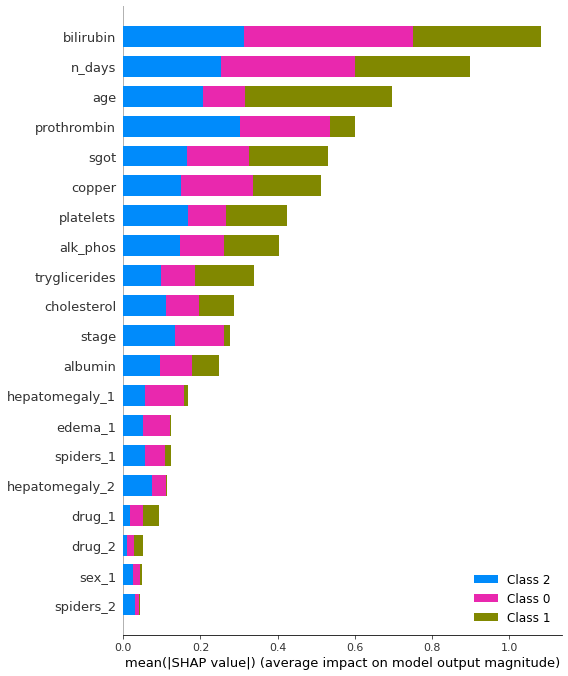

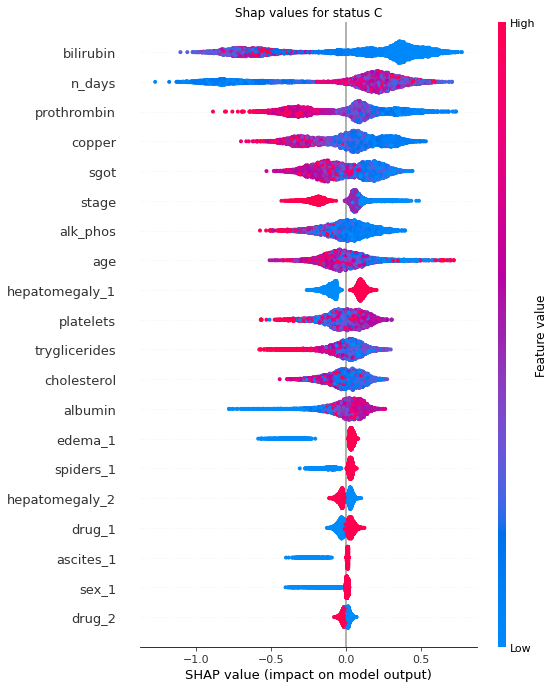

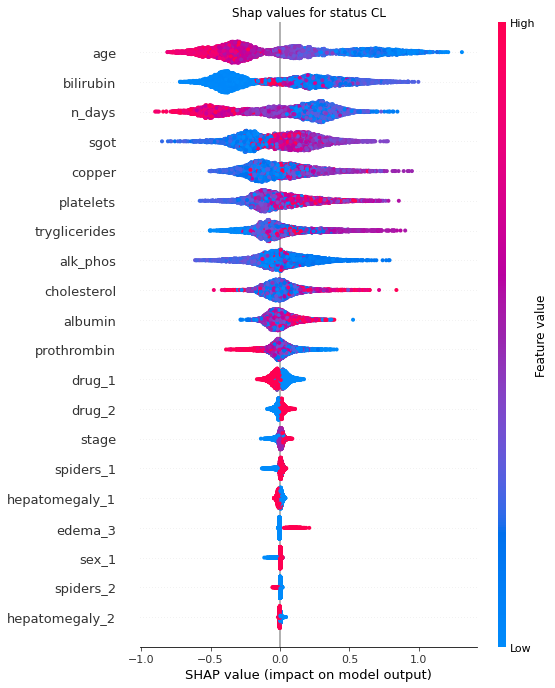

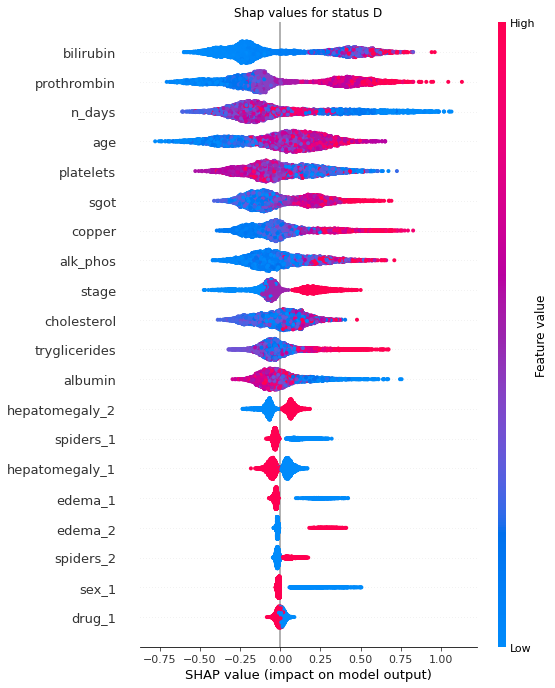

In [26]:
if target_type == 'continuous':     # graph not supported for multiclass
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      feature_names=X_train_preprocessed.columns, 
                      plot_type='dot')
else:
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      plot_type="bar", 
                      feature_names = X_train_preprocessed.columns)

    for i, tclass in enumerate(target_classes):
        shap.summary_plot(shap_values[i], 
                  X_train_preprocessed, 
                  plot_type="dot", 
                  feature_names = X_train_preprocessed.columns,
                  show=False) 
        plt.title(f'Shap values for {target} {tclass}')
        plt.show() 


#### Partial Dependence Plots

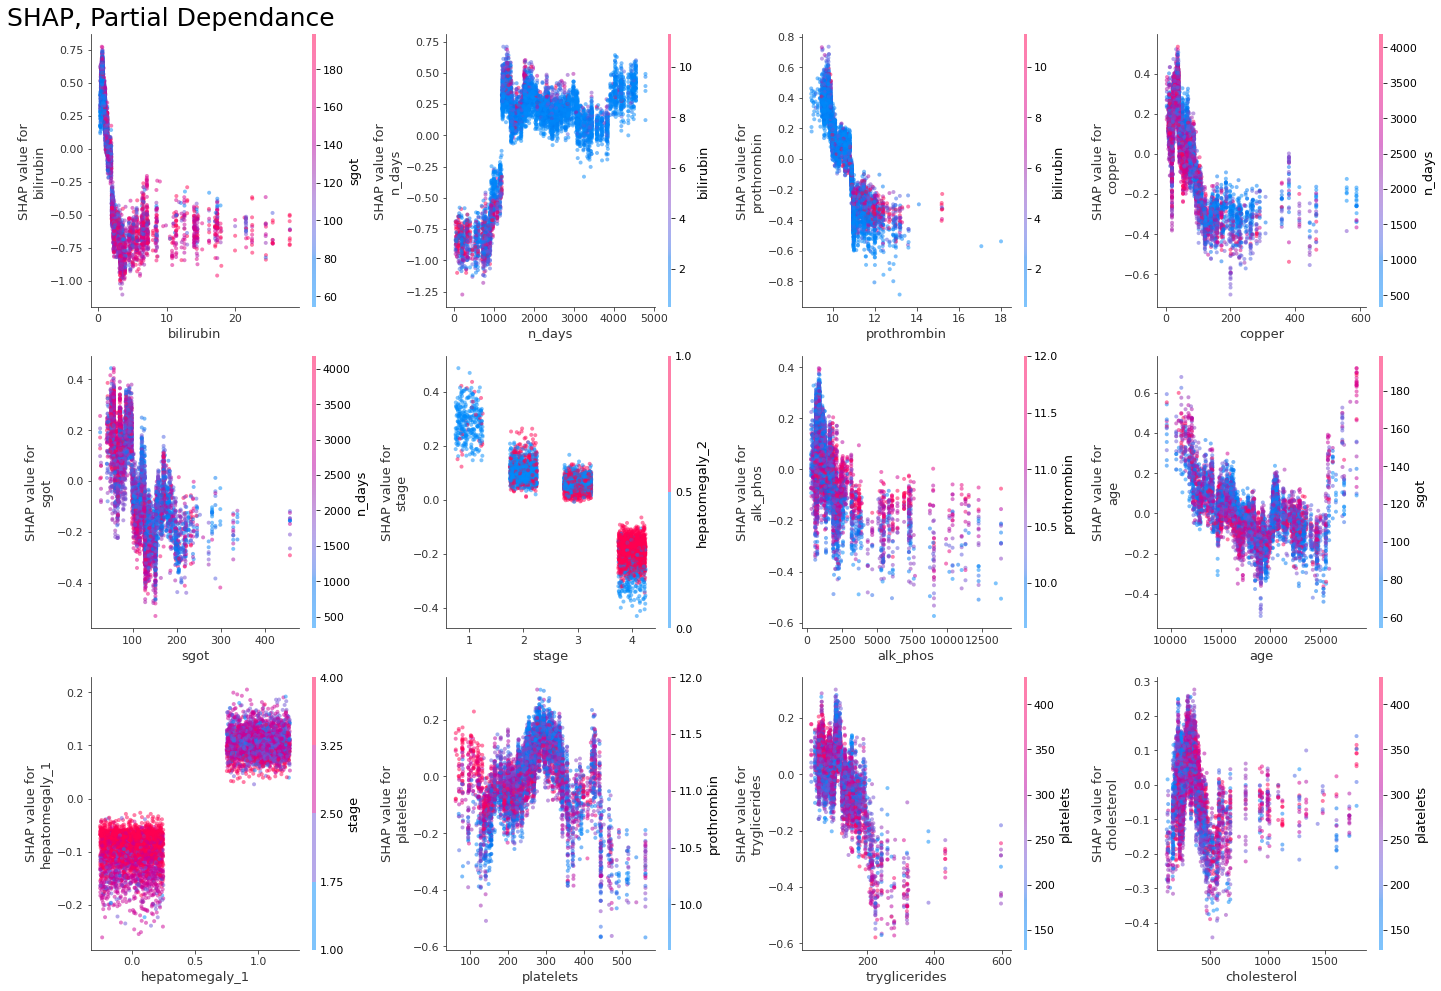

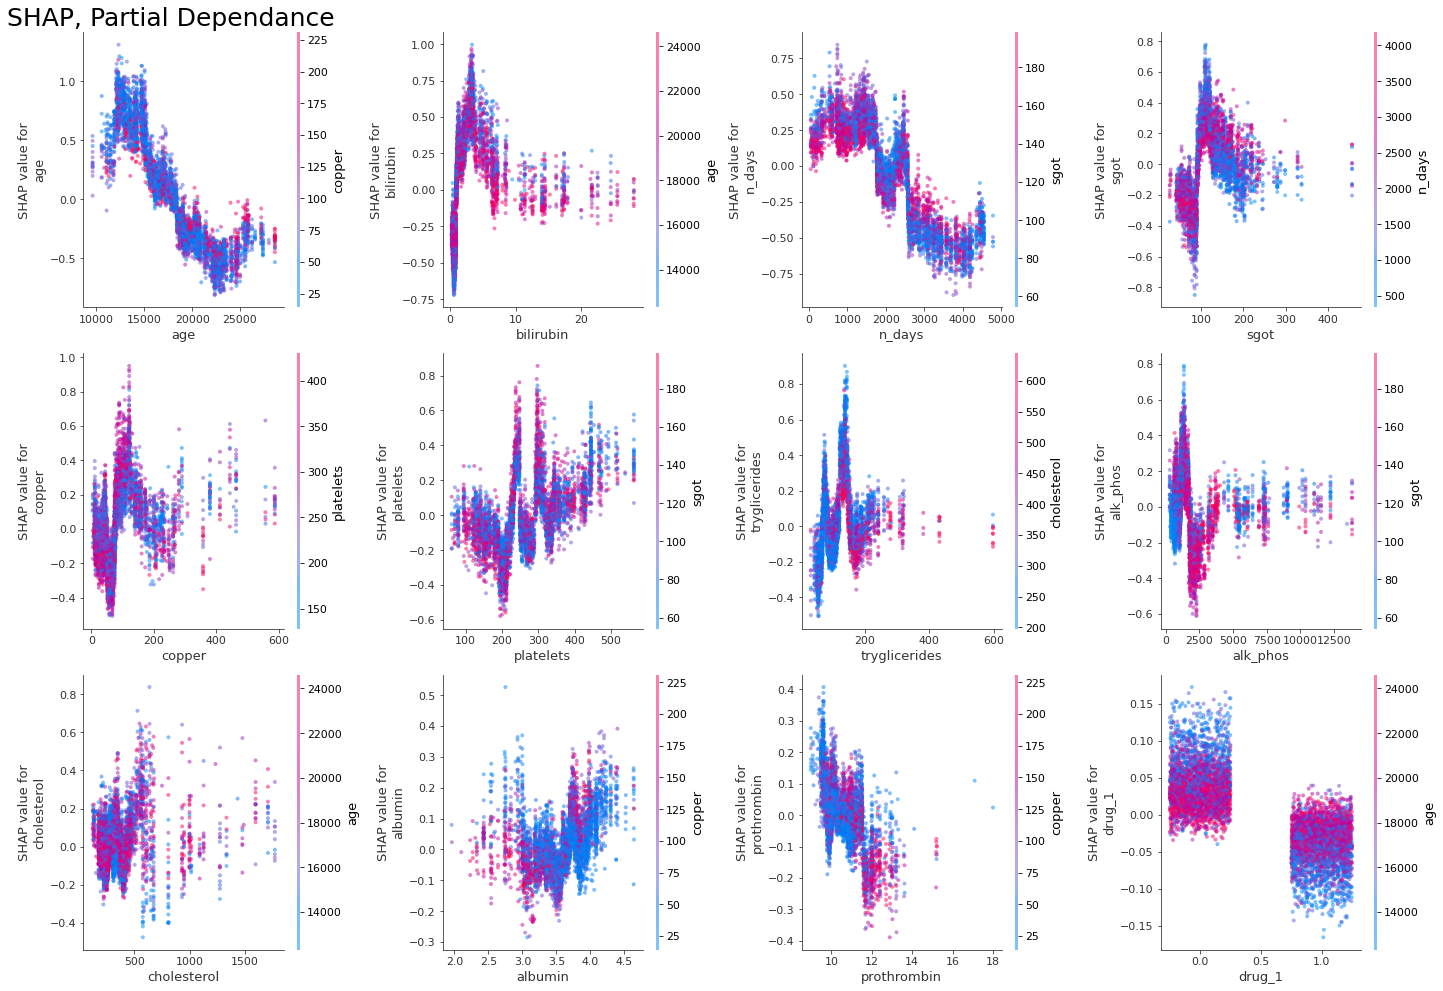

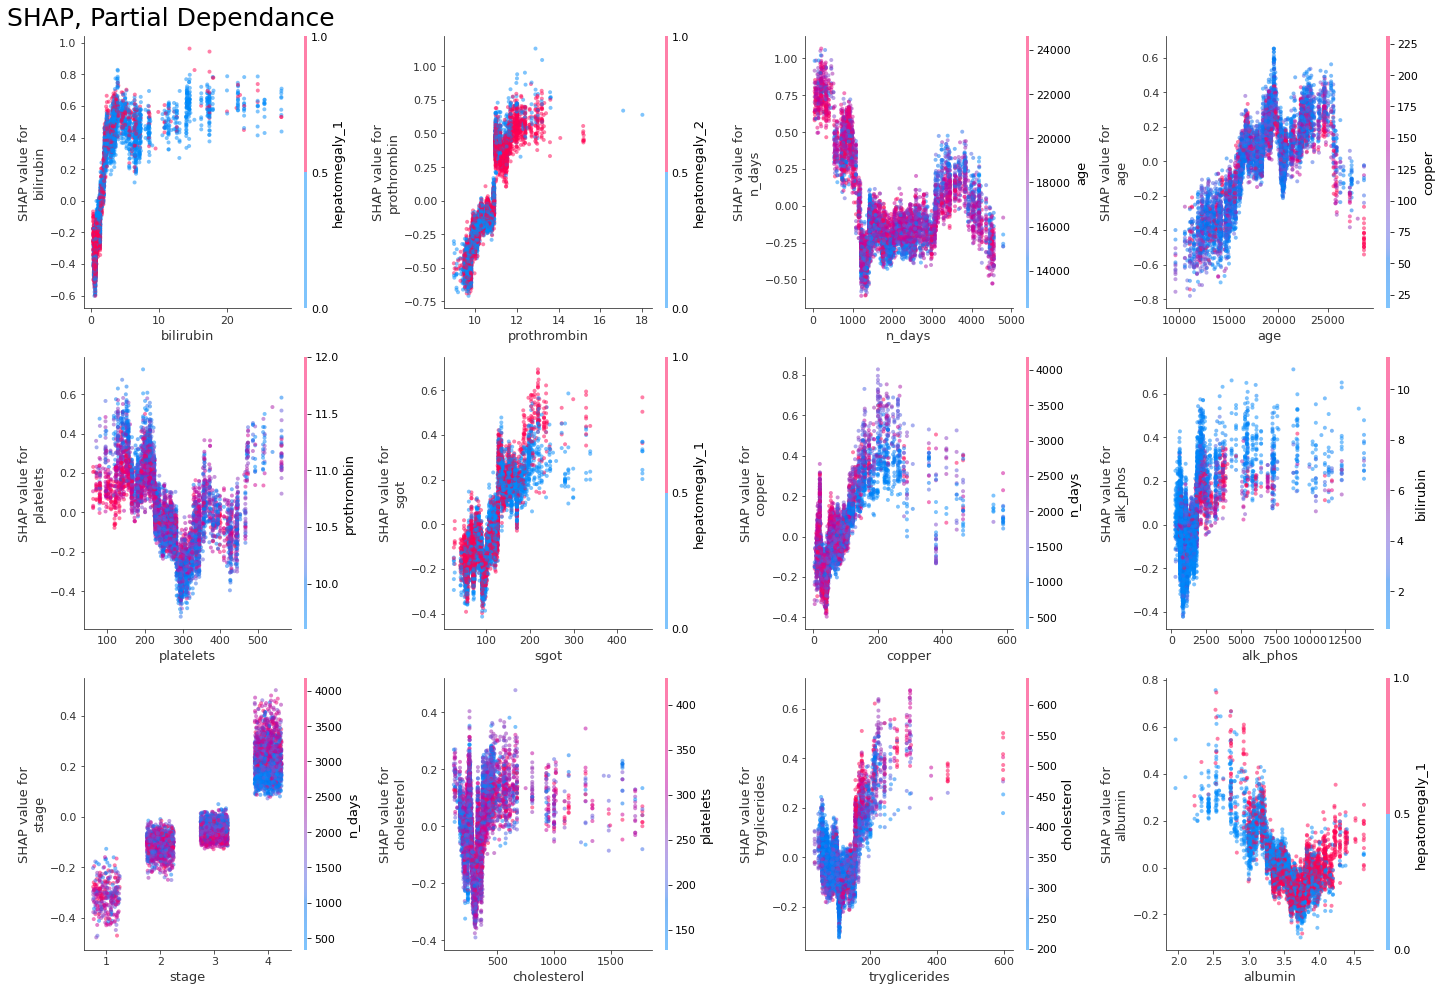

In [27]:
if target_type != 'continuous':
    # producing one graph for each class
    for i, tclass in enumerate(target_classes):
        mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values[i], n_charts=12) 
else:
    mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values, n_charts=12)

Takeaways from the previous graphs: 

### Model Predictions Analysis

#### Train Set

In [28]:
if target_type == 'continuous':
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed
                                           )
else:
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed, 
                                           label_encoder=le)

train_results

id  bilirubin  cholesterol  albumin  copper  alk_phos    sgot  \
0     2717        1.4        466.0     3.65    52.0     794.0  164.30   
1     7086        2.0        222.0     2.75   108.0     794.0  119.35   
2     1995        1.1        466.0     3.56   100.0    7394.8  170.50   
3     4095        0.7        215.0     3.67    23.0     613.0   71.30   
4     4318        1.2        392.0     3.67    52.0    1819.0  170.50   
...    ...        ...          ...      ...     ...       ...     ...   
6319  4931        0.7        303.0     3.87    69.0     646.0   71.30   
6320  3264        2.3        472.0     3.60   281.0   10396.8  188.34   
6321  1653        2.3        472.0     3.30    94.0     961.0  175.15   
6322  2607        0.9        216.0     3.34    28.0     648.0   60.45   
6323  2732        1.1        390.0     3.70    32.0     648.0   71.30   

      tryglicerides  platelets  prothrombin  ...  spiders_1  spiders_2  \
0             166.0      151.0         10.6  ...        1.0        0.0   
1              90.0      139.0         11.0  ...        1.0        0.0   
2             100.0      336.0          9.6  ...        1.0        0.0   
3              58.0      227.0         10.0  ...        1.0        0.0   
4              68.0      380.0         11.1  ...        1.0        0.0   
...             ...        ...          ...  ...        ...        ...   
6319          154.0      303.0         10.6  ...        1.0        0.0   
6320          272.0      311.0         11.0  ...        1.0        0.0   
6321           95.0      200.0         11.2  ...        0.0        1.0   
6322          188.0      211.0         10.1  ...        1.0        0.0   
6323           52.0      412.0          9.8  ...        1.0        0.0   

      edema_1  edema_2  edema_3  pred_prob_C  pred_prob_CL  pred_prob_D  \
0         1.0      0.0      0.0     0.623169      0.037101     0.339731   
1         0.0      1.0      0.0     0.016314      0.015055     0.968632   
2         1.0      0.0      0.0     0.881334      0.013114     0.105552   
3         1.0      0.0      0.0     0.939893      0.001495     0.058612   
4         1.0      0.0      0.0     0.937366      0.008392     0.054242   
...       ...      ...      ...          ...           ...          ...   
6319      1.0      0.0      0.0     0.977998      0.003636     0.018366   
6320      1.0      0.0      0.0     0.149321      0.032377     0.818302   
6321      1.0      0.0      0.0     0.069764      0.015685     0.914551   
6322      0.0      0.0      1.0     0.926158      0.002945     0.070897   
6323      1.0      0.0      0.0     0.983795      0.001937     0.014268   

      status_prediction  status  
0                     C       D  
1                     D       D  
2                     C       C  
3                     C       C  
4                     C       C  
...                 ...     ...  
6319                  C       C  
6320                  D       D  
6321                  D       D  
6322                  C       C  
6323                  C       C  

[6324 rows x 31 columns]

##### Overall Observations vs. Predictions plot

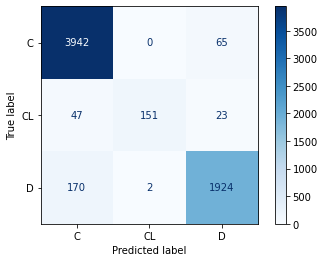

In [29]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=train_results[target],
                              y_pred=train_results[target + '_prediction'],
                              labels=target_classes)

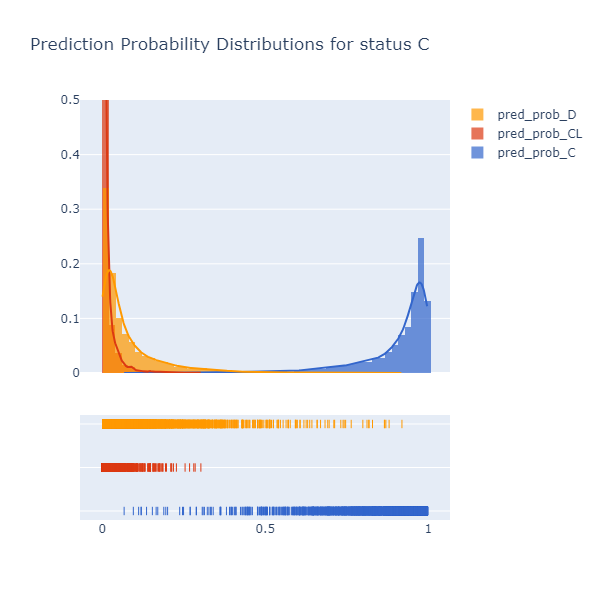

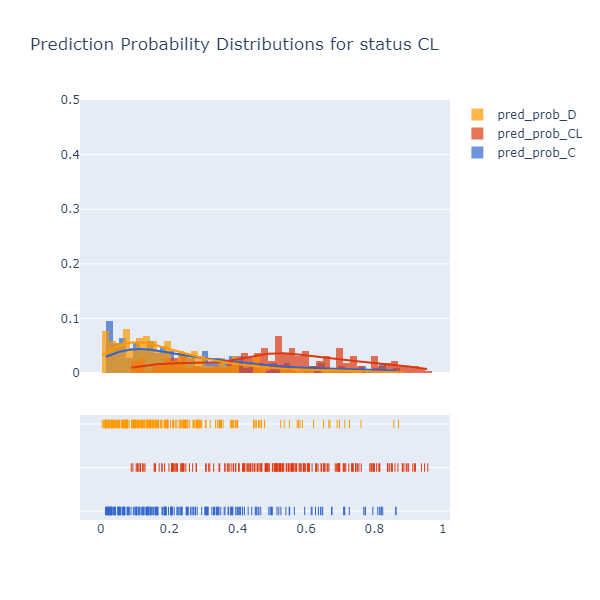

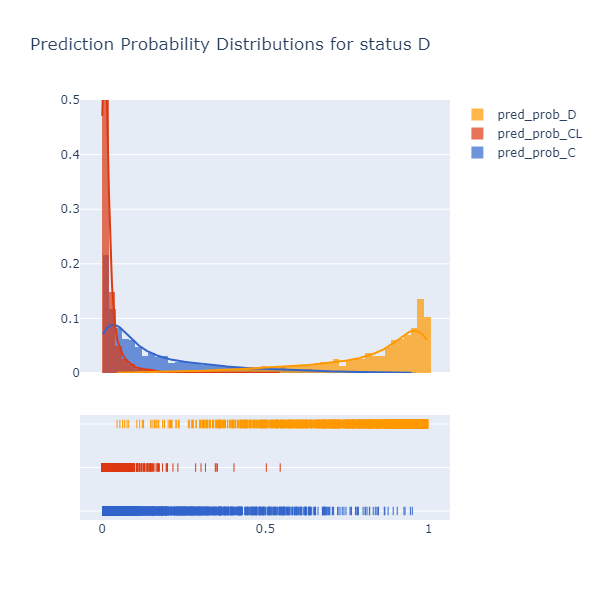

In [32]:
import plotly.express as px
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

# print(r2_score(train_results[target], train_results[f"{target}_prediction"]))
# print(mean_squared_log_error(train_results[target], train_results[f"{target}_prediction"]))


if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(train_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=train_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target,
                                                 renderer='png'
                                                 )


##### Single prediction waterfall plot

In [33]:
shap_explainer_values_train = explainer(X_train_preprocessed, y_train)

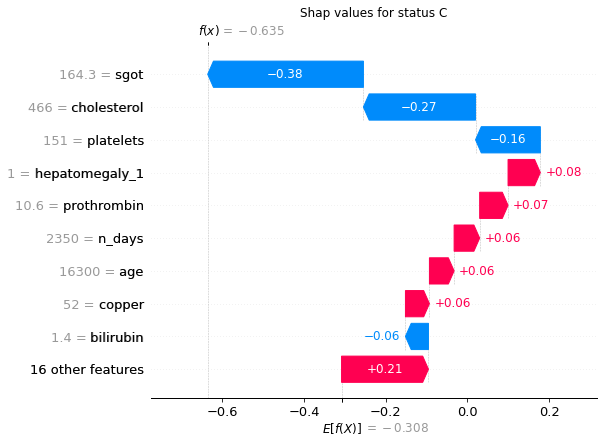

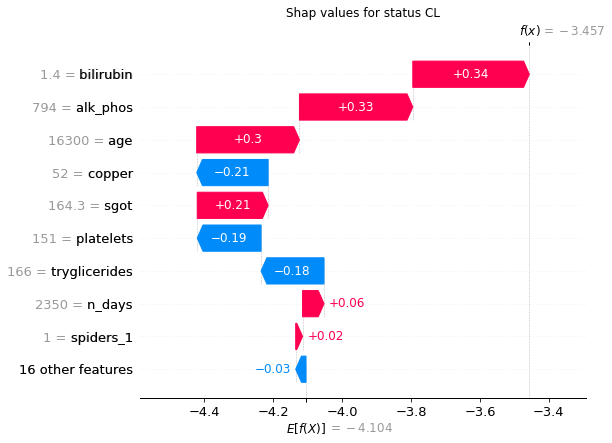

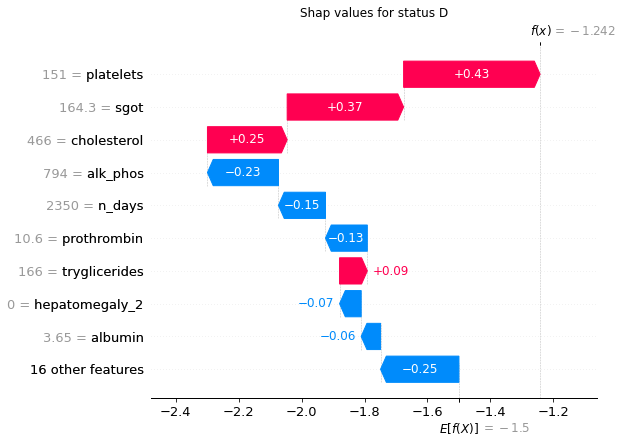

In [34]:
datapoint_id = 2717
idx = train_results[train_results.id == datapoint_id].index[0]
if target_type == 'continuous':
    shap.waterfall_plot(shap_explainer_values_train[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_train[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

#### Test Set

In [35]:
if target_type == 'continuous':
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed)
else:
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed, 
                                          label_encoder=le)

test_results

id  bilirubin  cholesterol  albumin  copper  alk_phos    sgot  \
0     3369        3.1        227.0     3.60   121.0    1134.0  110.00   
1     2617        0.7        253.0     3.74    41.0    1601.0  150.35   
2     2488        0.4        309.0     3.85    57.0     842.0   97.65   
3     1784        0.6        299.0     3.98    59.0    1387.0  127.10   
4     4209        1.3        248.0     3.58    73.0     944.0   97.65   
...    ...        ...          ...      ...     ...       ...     ...   
1576  7680        0.9        404.0     3.74    34.0    1866.0   79.05   
1577   555        1.8        322.0     3.70    48.0    1234.0   71.30   
1578  1785        0.9       1600.0     4.10    75.0    2656.0   82.15   
1579  5574        1.3        303.0     3.77    13.0    2108.0  128.65   
1580  2554        0.9        335.0     3.56    57.0   10396.8  110.05   

      tryglicerides  platelets  prothrombin  ...  spiders_1  spiders_2  \
0              91.0      270.0         10.0  ...        0.0        1.0   
1              68.0      295.0         11.4  ...        0.0        1.0   
2             101.0      309.0          9.5  ...        1.0        0.0   
3              56.0      301.0         10.5  ...        0.0        1.0   
4             114.0      252.0          9.7  ...        1.0        0.0   
...             ...        ...          ...  ...        ...        ...   
1576          224.0      236.0          9.9  ...        1.0        0.0   
1577          213.0      209.0         10.5  ...        1.0        0.0   
1578          174.0      354.0         10.9  ...        0.0        1.0   
1579           53.0      224.0         10.1  ...        1.0        0.0   
1580           55.0      223.0         10.8  ...        1.0        0.0   

      edema_1  edema_2  edema_3  pred_prob_C  pred_prob_CL  pred_prob_D  \
0         1.0      0.0      0.0     0.605072      0.209916     0.185012   
1         1.0      0.0      0.0     0.926942      0.006650     0.066408   
2         1.0      0.0      0.0     0.994409      0.001428     0.004163   
3         1.0      0.0      0.0     0.982702      0.003694     0.013604   
4         1.0      0.0      0.0     0.990656      0.004301     0.005044   
...       ...      ...      ...          ...           ...          ...   
1576      1.0      0.0      0.0     0.261088      0.010102     0.728810   
1577      1.0      0.0      0.0     0.923102      0.003507     0.073390   
1578      1.0      0.0      0.0     0.382922      0.015132     0.601946   
1579      1.0      0.0      0.0     0.943841      0.003867     0.052292   
1580      1.0      0.0      0.0     0.459279      0.009760     0.530961   

      status_prediction  status  
0                     C       C  
1                     C       C  
2                     C       C  
3                     C       C  
4                     C       C  
...                 ...     ...  
1576                  D       D  
1577                  C       C  
1578                  D       D  
1579                  C       C  
1580                  D       D  

[1581 rows x 31 columns]

##### Overall Observations vs. Predictions plot

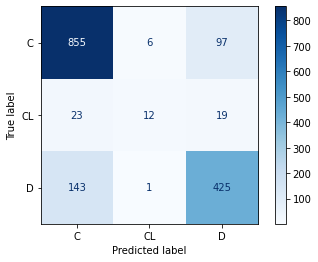

In [36]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=test_results[target],
                              y_pred=test_results[target + '_prediction'],
                              labels=target_classes)

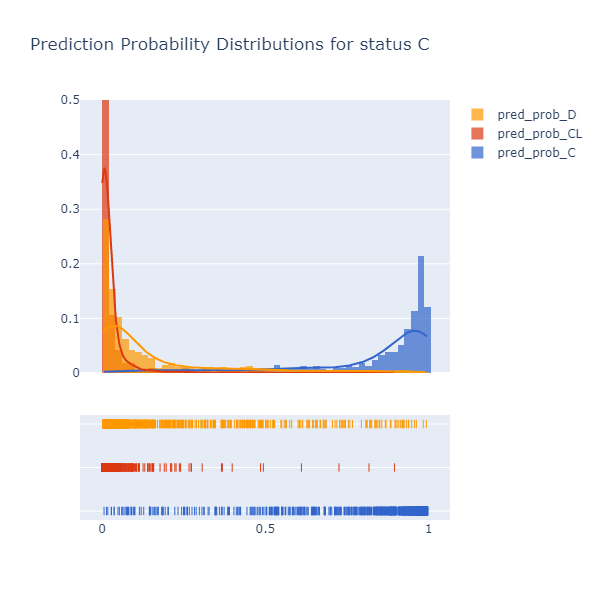

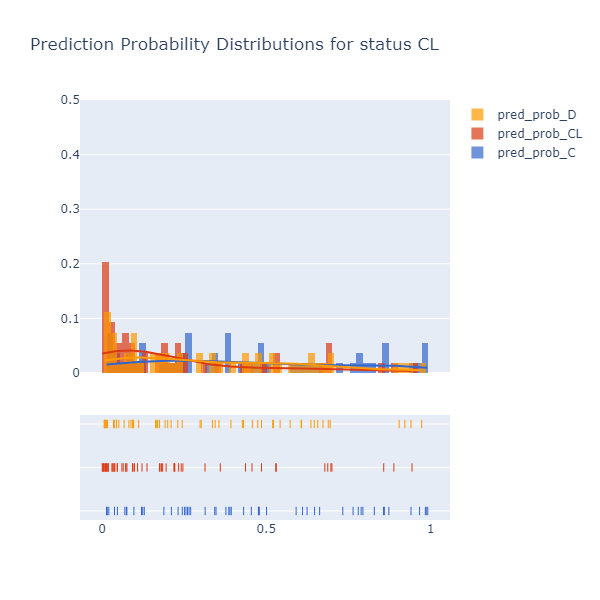

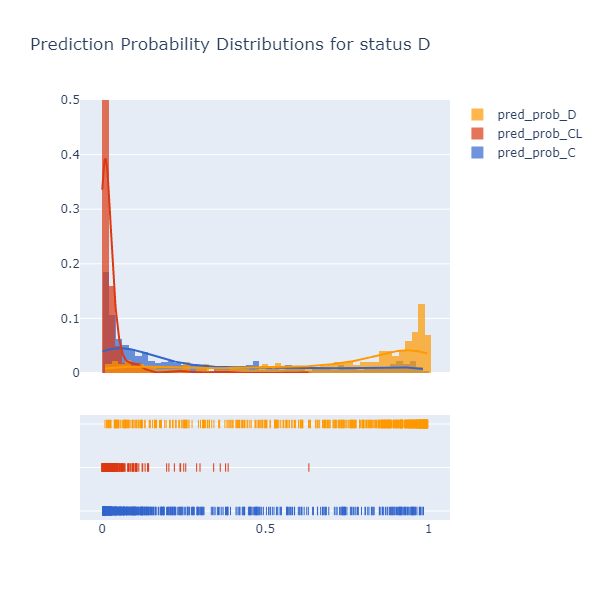

In [38]:
from sklearn.metrics import r2_score
# print(r2_score(test_results[target], test_results[f"{target}_prediction"]))
# print(mean_squared_log_error(test_results[target], test_results[f"{target}_prediction"].round(0)))

if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(test_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=test_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target,
                                                 renderer='png'
                                                 )


##### Single prediction waterfall plot

In [39]:
shap_explainer_values_test = explainer(X_test_preprocessed, y_test)

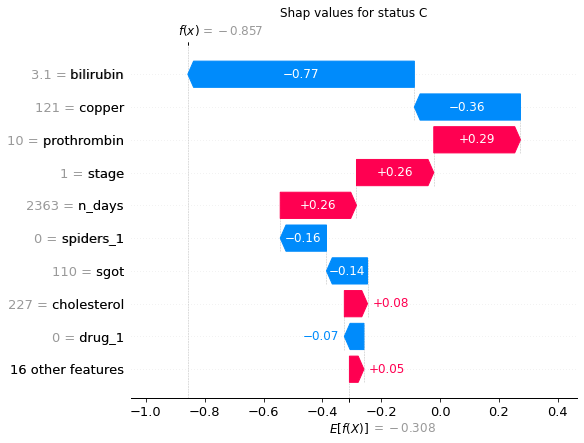

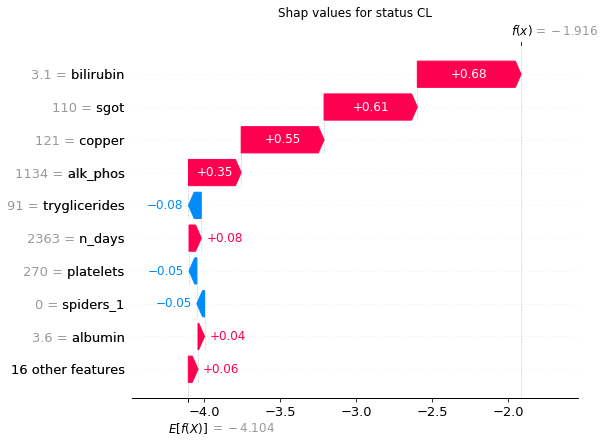

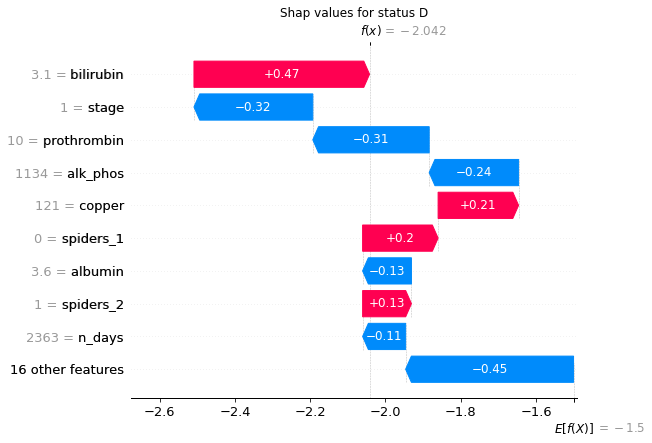

In [41]:
datapoint_id = 3369
idx = test_results[test_results.id == datapoint_id].index[0]
if target_type != 'multiclass':
    shap.waterfall_plot(shap_explainer_values_test[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_test[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

### Conclusion